In [3]:
import glob
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


img_paths = glob.glob('./img_align_celeba/*.jpg') # tải dữ liệu sử dụng glob

num_train, num_val = 200, 20 # bản demo với small data 
train_imgpaths = img_paths[ : num_train] # ảnh cho tập train 
val_imgpaths = img_paths[num_train : num_train + num_val] # ảnh cho tập val 

class ColorDataset():
    def __init__(self, img_paths, data_len=2880, image_size=(128, 128)):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths
        self.tfs = transforms.Resize((image_size[0], image_size[1]))
        
    def __getitem__(self, index):
        img_path = self.img_paths[index] #  Retrieve the image path from the img_paths attribute based on the given index.
        arr_img_bgr = cv2.imread(img_path) # Read the image file
        arr_img_lab = cv2.cvtColor(arr_img_bgr, cv2.COLOR_BGR2LAB) # chuyển ảnh từ màu BGR sang Lab
        arr_img_lab = ((arr_img_lab * 2.0) / 255.0)- 1.0  # Normalize from [0..255] to [-1..1]
        tens_img_lab = torch.tensor(arr_img_lab.transpose(2, 0, 1), dtype=torch.float32) #Create a PyTorch tensor from the LAB image array, transposing the dimensions to follow the convention of (channels, height, width).
        
        original_img_l = tens_img_lab[:1, :, :] #  Extract the L (lightness) channel of the LAB image
        tens_img_lab = self.tfs(tens_img_lab)
        tens_img_l = tens_img_lab[:1, :, :] # Extract the transformed L channel from the LAB image
        tens_img_ab = tens_img_lab[1:, :, :]  #  Extract the transformed a and b channels from the LAB image
        return original_img_l, tens_img_l, tens_img_ab
        
    def __len__(self):
        return len(self.img_paths)
# Create Dataset
train_dataset = ColorDataset(train_imgpaths, num_train)
val_dataset = ColorDataset(val_imgpaths, num_val)
# Create DataLoader
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# UNET 
from github of difusion model beat Gan in image systhesis : https://github.com/openai/guided-diffusion.

In [4]:
import math
import numpy as np
import torch
import torch.nn as nn


class GroupNorm32(nn.GroupNorm):

    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)  # to cast the input x to float
def zero_module(module):
    
    for p in module.parameters():
        p.detach().zero_()
    return module
def scale_module(module, scale):
    
    for p in module.parameters():
        p.detach().mul_(scale) # multiplies all parameters of the given module by the specified scale and returns the module
    return module
    
def mean_flat(tensor):
    
    return tensor.mean(dim=list(range(1, len(tensor.shape)))) # computes the mean of the tensor over all dimensions except the first (batch dimension)
    
    
def normalization(channels):
    
    return GroupNorm32(32, channels)

def checkpoint(func, inputs, params, flag):
    
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)
    
    
class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors
            
    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
                output_tensors,
                ctx.input_tensors + ctx.input_params,
                output_grads,
                allow_unused=True,
                )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads
def count_flops_attn(model, _x, y):
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    matmul_ops = 2 * b * (num_spatial ** 2) * c # We perform two matmuls with the same number of ops.The first computes the weight matrix, the second computes the combination of the value vectors.
    model.total_ops += torch.DoubleTensor([matmul_ops])
            
def gamma_embedding(gammas, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=gammas.device)
    args = gammas[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])],dim=-1)
    return embedding

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from abc import abstractmethod

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
 
class EmbedBlock(nn.Module):
    """
    Any module where forward() takes embeddings as a second argument.
    """
    
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to 'x' given 'emb' embeddings.
        """
 
class EmbedSequential(nn.Sequential, EmbedBlock):
    
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, EmbedBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x
class Upsample(nn.Module):
    
 
    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(self.channels, self.out_channel, 3, padding=1)
    
    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x
 
class Downsample(nn.Module):
    
    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels # param channels: channels in the inputs and outputs.
        self.out_channel = out_channel or channels
        self.use_conv = use_conv # param use_conv: a bool determining if a convolution is applied
        
        stride = 2
        if use_conv:
            self.op = nn.Conv2d(
                self.channels, self.out_channel, 3, stride=stride, padding=1
                )
        else:
            assert self.channels == self.out_channel
            self.op = nn.AvgPool2d(kernel_size=stride, stride=stride)
  
    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)
    
 
class ResBlock(EmbedBlock):

    def __init__(
        self,
        channels, 
        emb_channels,
        dropout,
        out_channel=None,
        use_conv=False,
        use_scale_shift_norm=False,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels # param channels: the number of input channels.
        self.emb_channels = emb_channels # param emb_channels: the number of embedding channels.
        self.dropout = dropout # param dropout: the rate of dropout.
        self.out_channel = out_channel or channels # param out_channel: if specified, the number of out channels.
        self.use_conv = use_conv  # param use_conv: if True and out_channel is specified, use a spatial convolution instead of a smaller 1x1 convolution to change thechannels in the skip connection.
        self.use_checkpoint = use_checkpoint # param use_checkpoint: if True, use gradient checkpointing on this module.
        self.use_scale_shift_norm = use_scale_shift_norm
 
        self.in_layers = nn.Sequential(
        normalization(channels),
        SiLU(),
        nn.Conv2d(channels, self.out_channel, 3, padding=1),
        )
        
        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()
        
        self.emb_layers = nn.Sequential(
            SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channel if use_scale_shift_norm else self.out_channel,
                ),
            )
        self.out_layers = nn.Sequential(
        normalization(self.out_channel),
        SiLU(),
        nn.Dropout(p=dropout),
        zero_module(
        nn.Conv2d(self.out_channel, self.out_channel, 3, padding=1)
        ),
        )
 
        if self.out_channel == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
              self.skip_connection = nn.Conv2d(
        channels, self.out_channel, 3, padding=1
        )
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channel, 1)
        
    def forward(self, x, emb):
        
        return checkpoint(
        self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )
    
    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]  
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h    
class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1
    e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
    self,
    channels,
    num_heads=1,
    num_head_channels=-1,
    use_checkpoint=False,
    use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels ==-1:
            self.num_heads = num_heads
        else:
            assert (
            channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels{num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        if use_new_attention_order:
            self.attention = QKVAttention(self.num_heads)  # split qkv before split heads
        else:
            self.attention = QKVAttentionLegacy(self.num_heads) # split heads before split qkv
        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)
    
    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c,-1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/
    ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        ) # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs,-1, length)
 
    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)
 
 
class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """
    
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads
    
    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
         """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        ) # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch,length))
        return a.reshape(bs,-1, length)
    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)
    

class UNet(nn.Module):
   
    def __init__(
    self,
    image_size,
    in_channel, # param in_channel: channels in the input Tensor, for image colorization :Y_channels + X_channels 
    inner_channel,  # param inner_channel: base channel count for the model.
    out_channel, # param out_channel: channels in the output Tensor.
    res_blocks, # param res_blocks: number of residual blocks per downsample.
    attn_res, # param attn_res:  a collection of downsample rates at which attention will take place. May be a set, list, or tuple.
    dropout=0, # param dropout: the dropout probability.
    channel_mults=(1, 2, 4, 8), # param channel_mults: channel multiplier for each level of the UNet.
    conv_resample=True,  # param conv_resample: if True, use learned convolutions for upsampling and downsampling.
    use_checkpoint=False,
    use_fp16=False,
    num_heads=1, # param num_heads: the number of attention heads in each attention layer.
    num_head_channels=-1, # param num_heads_channels: if specified, ignore num_heads and instead use a fixed channel width per attention head.
    num_heads_upsample=-1, 
    use_scale_shift_norm=True, # param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    resblock_updown=True, # param resblock_updown: use residual blocks for up/downsampling.
    use_new_attention_order=False, # param use_new_attention_order: use a different attention pattern for potentially increased efficiency.
    ):

        super().__init__()

        if num_heads_upsample ==-1:
            num_heads_upsample = num_heads
        self.image_size = image_size
        self.in_channel = in_channel
        self.inner_channel = inner_channel
        self.out_channel = out_channel
        self.res_blocks = res_blocks
        self.attn_res = attn_res
        self.dropout = dropout
        self.channel_mults = channel_mults
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = torch.float16 if use_fp16 else torch.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        cond_embed_dim = inner_channel * 4
        self.cond_embed = nn.Sequential(
            nn.Linear(inner_channel, cond_embed_dim),
            SiLU(),
            nn.Linear(cond_embed_dim, cond_embed_dim))
            
        ch = input_ch = int(channel_mults[0] * inner_channel)
        self.input_blocks = nn.ModuleList(
            [EmbedSequential(nn.Conv2d(in_channel, ch, 3, padding=1))])
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mults):
            for _ in range(res_blocks):
                layers = [
                    ResBlock(
                        ch, 
                        cond_embed_dim,
                        dropout, 
                        out_channel= int(mult * inner_channel),
                        use_checkpoint= use_checkpoint,
                        use_scale_shift_norm= use_scale_shift_norm,
                        )
                    ]
                ch = int(mult * inner_channel)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint = use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                            )
                    )
                self.input_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mults)- 1:
                out_ch = ch
                self.input_blocks.append(
                    EmbedSequential(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                            )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, out_channel=out_ch
                            )
                    )
                    )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch
                    
        self.middle_block = EmbedSequential(
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
                ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
                ),
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
                ),
            )
        self._feature_size += ch
                    
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mults))[::-1]:
            for i in range(res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        cond_embed_dim,
                        dropout,
                        out_channel=int(inner_channel * mult),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                        )
                    ]
                ch = int(inner_channel * mult)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                            )
                    )
                if level and i == res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                            )
                            if resblock_updown
                            else Upsample(ch, conv_resample, out_channel=out_ch)
                        )
                    ds //= 2
                self.output_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch
                            
        self.out = nn.Sequential(
            normalization(ch),
            SiLU(),
            zero_module(nn.Conv2d(input_ch, out_channel, 3, padding=1)),
        )
    def forward(self, x, gammas):
        hs = []
        gammas = gammas.view(-1, )
        emb = self.cond_embed(gamma_embedding(gammas, self.inner_channel))
            
        h = x.type(torch.float32)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
            h = h.type(x.dtype)
        return self.out(h)

In [6]:
def make_beta_schedule(schedule, n_timestep, linear_start=1e-5, linear_end=1e-2):
    if schedule == 'linear':
        betas = np.linspace(
        linear_start, linear_end, n_timestep, dtype=np.float64
 )
    else:
        raise NotImplementedError(schedule)
    return betas

def get_index_from_list(vals, t, x_shape=(1,1,1,1)):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size, *_ = t.shape
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape)- 1))).to(device)

In [7]:
from tqdm import tqdm
from functools import partial

class ColorDiffusion(nn.Module):
    def __init__(self, unet_config, beta_schedule, **kwargs):
        super(ColorDiffusion, self).__init__(**kwargs)
        self.denoise_fn = UNet(**unet_config)
        self.beta_schedule = beta_schedule

    def set_new_noise_schedule(self, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)
        betas = make_beta_schedule(**self.beta_schedule)
        alphas = 1.-betas
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        
        gammas = np.cumprod(alphas, axis=0) # alphas_cumprod
        gammas_prev = np.append(1., gammas[:-1])
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('gammas', to_torch(gammas))
        self.register_buffer('sqrt_recip_gammas', to_torch(np.sqrt(1. / gammas)))
        self.register_buffer('sqrt_recipm1_gammas', to_torch(np.sqrt(1. / gammas- 1)))
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1.-gammas_prev) / (1.-gammas)
        # below: log calculation clipped because the posterior variance is 0 at  the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(gammas_prev) / (1.-gammas)))
        self.register_buffer('posterior_mean_coef2', to_torch((1.-gammas_prev)* np.sqrt(alphas) / (1.-gammas)))

    def set_loss(self, loss_fn):
        self.loss_fn = loss_fn
    
    def predict_start_from_noise(self, y_t, t, noise):
        return (
            get_index_from_list(self.sqrt_recip_gammas, t, y_t.shape) * y_t - get_index_from_list(self.sqrt_recipm1_gammas, t, y_t.shape) * noise
                )
    
    def q_posterior(self, y_0_hat, y_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

        q(x_{t-1} | x_t, x_0)

        """
        posterior_mean = (
        get_index_from_list(self.posterior_mean_coef1, t, y_t.shape) * y_0_hat + get_index_from_list(self.posterior_mean_coef2, t, y_t.shape) * y_t
        )
        posterior_log_variance_clipped = get_index_from_list(
            self.posterior_log_variance_clipped, t, y_t.shape
        )
        return posterior_mean, posterior_log_variance_clipped
        
    def p_mean_variance(self, y_t, t, clip_denoised: bool, y_cond=None):
        noise_level = get_index_from_list(self.gammas, t, x_shape=(1, 1)).to(y_t.device)
        y_0_hat = self.predict_start_from_noise(y_t, t=t, noise=self.denoise_fn(torch.cat([y_cond, y_t], dim=1),noise_level))
        
        if clip_denoised:
            y_0_hat.clamp_(-1., 1.)
        
        model_mean, posterior_log_variance = self.q_posterior(y_0_hat=y_0_hat, y_t=y_t, t=t)
        return model_mean, posterior_log_variance
    
    def q_sample(self, y_0, sample_gammas, noise=None):
        noise = noise if noise is not None else torch.randn_like(y_0)
        return (sample_gammas.sqrt() * y_0 +(1-sample_gammas).sqrt() * noise)
    
    @torch.no_grad()
    def p_sample(self, y_t, t, clip_denoised=True, y_cond=None):
        model_mean, model_log_variance = self.p_mean_variance(y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond)
        noise = torch.randn_like(y_t) if any(t>0) else torch.zeros_like(y_t)
        return model_mean + noise * (0.5 * model_log_variance).exp()
   
    @torch.no_grad()
    def restoration(self, y_cond, y_t=None, y_0=None, sample_num=8):
        b, _, h, w = y_cond.shape
        
        sample_inter = (self.num_timesteps//sample_num)
        
        y_t = y_t if y_t is not None else torch.randn((b, 2, h, w))
        y_t = y_t.to(y_cond.device)
        ret_arr = y_t
        for i in reversed(range(0, self.num_timesteps)):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            y_t = self.p_sample(y_t, t, y_cond=y_cond)
            ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr
 
    def forward(self, y_0, y_cond=None, noise=None):
        b, *_ = y_0.shape
        t = torch.randint(1, self.num_timesteps, (b,), device=y_0.device).long()
        gamma_t1 = get_index_from_list(self.gammas, t-1, x_shape=(1, 1))
        sqrt_gamma_t2 = get_index_from_list(self.gammas, t, x_shape=(1, 1))
        sample_gammas = (sqrt_gamma_t2-gamma_t1) * torch.rand((b, 1), device=y_0.device) + gamma_t1
        sample_gammas = sample_gammas.view(b,-1)
        
        noise = noise if noise is not None else torch.randn_like(y_0)
        y_noisy = self.q_sample(
        y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1, 1), noise=noise)
        
        noise_hat = self.denoise_fn(torch.cat([y_cond, y_noisy], dim=1),sample_gammas)
        loss = self.loss_fn(noise, noise_hat)
        return loss
        

In [8]:
unet_config = {
  "in_channel": 3,
  "out_channel": 2,
  "inner_channel": 64,
  "channel_mults": [1, 2, 4, 8],
  "attn_res": [16],
  "num_head_channels": 32,
  "res_blocks": 2,
  "dropout": 0.2,
  "image_size": 128
 }
 
beta_schedule = {
  "schedule": "linear",
  "n_timestep": 20,
  "linear_start": 1e-4,
  "linear_end": 0.09
}

colordiff_model = ColorDiffusion(unet_config, beta_schedule)

In [9]:
import torch.nn.functional as F

def mse_loss(output, target):
    return F.mse_loss(output, target) # được kiểm chứng qua quá trình thực nghiệm bởi Saharia,C. và các cộng sự


def mae(input, target):
    with torch.no_grad():
        loss = nn.L1Loss()
        output = loss(input, target)
    return output

In [10]:
import time
import wandb
class Trainer():

    def __init__(self, model, optimizers, train_loader,val_loader, epochs, sample_num, device, save_model, use_wandb=True):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(list(filter(lambda p: p.requires_grad, self.model.parameters())), **optimizers)
        self.model.set_loss(mse_loss)
        self.model.set_new_noise_schedule(device)
        self.sample_num = sample_num
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        self.save_model = save_model
        self.use_wandb = use_wandb
    def train_step(self):
        self.model.train()
        losses = []
        for original_gray, gray, color in tqdm(self.train_loader):
            cond_gray = gray.to(self.device)
            gt_color = color.to(self.device)
            self.optimizer.zero_grad()

            loss = self.model(gt_color, cond_gray)
            loss.backward()

            losses.append(loss.item())
            self.optimizer.step()
        return sum(losses)/len(losses)
 
    def val_step(self, epoch):
        self.model.eval()
        losses, metrics = [], []
        pred_images = []
        gt_images = []
        
        with torch.no_grad():
            for i, (original_gray, gray, color) in tqdm(enumerate(self.val_loader)):
                cond_gray = gray.to(self.device)
                gt_color = color.to(self.device)
                loss = self.model(gt_color, cond_gray)
                
                output, visuals = self.model.restoration(cond_gray, sample_num=self.sample_num)
                if i == 0:
                    for i in range(output.shape[0]):
                # predicted image
                        pred_bgr_image = self.show_wandb_image(original_gray[i],output[i].detach().cpu())
                        pred_wandb_image = wandb.Image(pred_bgr_image, caption=f"epoch {epoch}")
                        pred_images.append(pred_wandb_image)
                        #  grouth truth image
                        gt_bgr_image = self.show_wandb_image(original_gray[i],color[i])
                        gt_wandb_image = wandb.Image(gt_bgr_image, caption=f"epoch {epoch}")
                        gt_images.append(gt_wandb_image)
        
                mae_score = mae(gt_color, output)
                losses.append(loss.item())
                metrics.append(mae_score.item())
        return sum(losses)/len(losses), sum(metrics)/len(metrics), pred_images,gt_images
 
  # Postprocess the image before logging to WanDB
    def show_wandb_image(self, img_l, img_ab, is_save=False):
        img_l = img_l.permute(1, 2, 0).numpy()
        img_ab = img_ab.permute(1, 2, 0).numpy()
        img_ab = cv2.resize(img_ab, (img_l.shape[1], img_l.shape[0]),interpolation=cv2.INTER_LINEAR)
        arr_lab = np.concatenate([img_l, img_ab], axis=2)
        arr_lab = (arr_lab + 1.0) * 255 / 2
        arr_lab = np.clip(arr_lab, 0, 255).astype(np.uint8)
        arr_bgr = cv2.cvtColor(arr_lab, cv2.COLOR_LAB2RGB)
        return arr_bgr  
    def train(self):
        best_mae = 100000
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            train_loss = self.train_step()
            val_loss, val_mae, pred_images, gt_images = self.val_step(epoch)
        
        # Log the results to WanDB
            if self.use_wandb:
                wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "val_mae": val_mae,
                    "pred_images": pred_images,
                    "gt_images": gt_images
                    })
            
            if val_mae < best_mae:
                torch.save(self.model.state_dict(), self.save_model)
            # Print loss, acc end epoch
            print("-" * 59)
            print(
                "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
                "| Valid Loss {:8.3f} | Valid MAE {:8.3f} ".format(
                    epoch+1, time.time()-epoch_start_time,
                    train_loss, val_loss, val_mae
            )
            )
            print("-" * 59)
        self.model.load_state_dict(torch.load(self.save_model))

In [11]:
epochs = 3
sample_num = 8
save_model = './save_model/best_model.pth'
optimizers = { "lr": 5e-5, "weight_decay": 0}
device = "cuda" if torch.cuda.is_available() else "cpu"
use_wandb = True

trainer = Trainer(
    colordiff_model, optimizers,
    train_loader, val_loader,
    epochs, sample_num,
    device, save_model,
    use_wandb
)

In [12]:
if use_wandb:
    wandb_api="e4fedfff12a507fff74d2a8483f70da02842e3ef"
    wandb.login(key=wandb_api)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nmquang (mquang). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Admin\.netrc


In [13]:
if use_wandb :

   wandb.init(

 # set the wandb project where this run will be logged
   project="my-diff-color",
 # track hyperparameters and run metadata
   config={
    "learning_rate": optimizers["lr"],
    "weight_decay": optimizers["weight_decay"],
    "architecture": "UNet",
    "dataset": "CelebA",
    "epochs": epochs,
    "save_model": save_model,
    "sample_num": sample_num
    }
    )

In [14]:
# trainer.train()

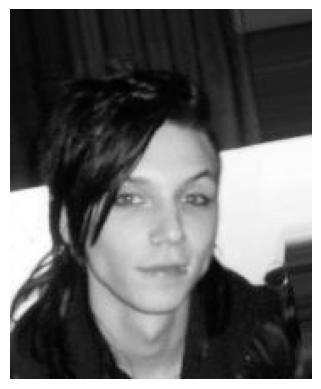

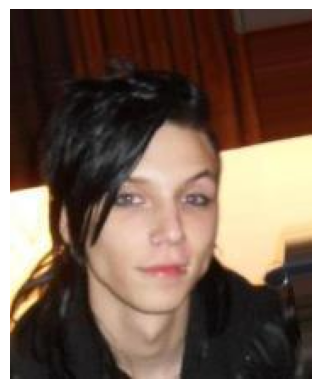

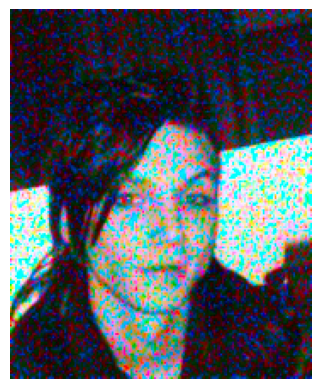

In [15]:
from matplotlib import pyplot as plt
colordiff_model = ColorDiffusion(unet_config, beta_schedule)
colordiff_model.set_new_noise_schedule(device)
load_state = torch.load('./save_model/best_model.pth')
colordiff_model.load_state_dict(load_state, strict=True)
colordiff_model.eval().to(device)

showed_img_idx = 55
img_path = img_paths[showed_img_idx]
img_bgr = cv2.imread(img_path)

img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
img_l = img_lab[:,:,:1]
plt.imshow(img_l, cmap='gray')
plt.axis(False)
plt.savefig("e1_gray.png")
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis(False)
plt.savefig("e2_full_color.png")
plt.show()

test_imgpath = img_paths[showed_img_idx]
test_dataset = ColorDataset([test_imgpath])
test_sample = next(iter(test_dataset))
def inference(model, test_sample):
    with torch.no_grad():
        output, visuals = model.restoration(
        test_sample[1].unsqueeze(0).to(device)
        )
    return output, visuals

output, visuals = inference(colordiff_model, test_sample)

def show_tensor_image(img_l, img_ab, is_save=False):
    img_l = img_l.permute(1, 2, 0).numpy()
    img_ab = img_ab.permute(1, 2, 0).numpy()
    img_ab = cv2.resize(img_ab, (img_l.shape[1], img_l.shape[0]), interpolation=
    cv2.INTER_LINEAR)
    arr_lab = np.concatenate([img_l, img_ab], axis=2)
    arr_lab = (arr_lab + 1.0) * 255 / 2
    arr_lab = np.clip(arr_lab, 0, 255).astype(np.uint8)
    arr_bgr = cv2.cvtColor(arr_lab, cv2.COLOR_LAB2BGR)
    if is_save:
        cv2.imwrite("results.png", arr_bgr)
    arr_bgr = cv2.cvtColor(arr_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(arr_bgr)
    plt.axis(False)
        
output, visuals = inference(colordiff_model, test_sample)
show_tensor_image(test_sample[0], output[0].cpu(), is_save=True)
plt.show()